# Introduction:
Proposing a neural network architecture capable of classifying protein organelle localization labels, the proposed model was able to reach an accuracy of 95 percent for test data and training data.
The proposed model deals with the input of the proposed neural network as three-dimensional (each dimension represents colors (red filter, blue filter, yellow filter, green filter)), and thus the input to the neural network (samples, 2, 90, 90, 3) represents the number 2 In the proposed structure (RGB image, image with yellow filter).

#Download Dataset:

In [9]:
!kaggle competitions download -c human-protein-atlas-image-classification

100% 17.4G/17.5G [01:57<00:00, 200MB/s]
100% 17.5G/17.5G [01:57<00:00, 160MB/s]


In [ ]:
!unzip human-protein-atlas-image-classification.zip

#Import Packages:

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib as p
import os
import matplotlib.pyplot as plt
import cv2

#Read Dataset (Images, CSV):

In [3]:
dataset_folder = os.path.join("train")
datasetObject = p.Path(dataset_folder)
dataset_images = list(datasetObject.glob("*.*"))

In [4]:
len(dataset_images)

124288

In [5]:
csv_dataset = pd.read_csv("train.csv")
csv_dataset.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
len(csv_dataset)

31072

In [7]:
target = csv_dataset['Target']
target.head()

0       16 0
1    7 1 2 0
2          5
3          1
4         18
Name: Target, dtype: object

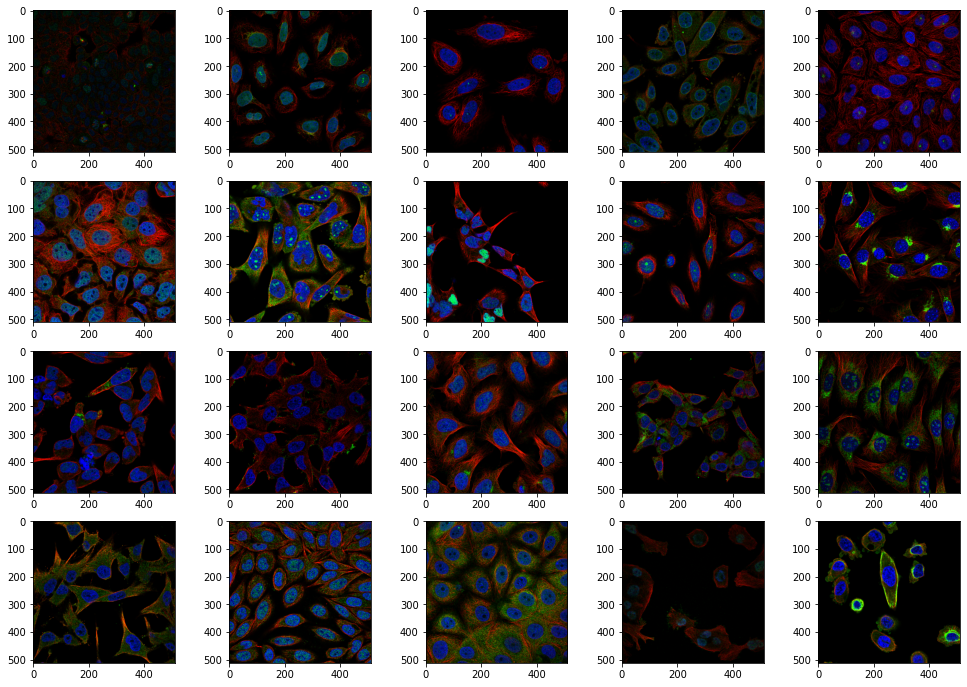

In [21]:
IDs = csv_dataset['Id']
plt.figure(figsize = (17, 12))
for i in range(20):
  plt.subplot(4, 5, i + 1)
  red= cv2.imread("train/{}_red.png".format(str(IDs[i])), 0)
  green = cv2.imread("train/{}_green.png".format(str(IDs[i])), 0)
  blue = cv2.imread("train/{}_blue.png".format(str(IDs[i])), 0)
  image = np.stack((red, green, blue), -1)
  plt.imshow(image)
plt.show()

#Preprocessing Dataset Images:

In [13]:
def reszie_and_scale_image(img, target_size):
  img = cv2.resize(img, target_size)
  img = img/255
  return img

In [14]:
def read_img(paths):
  red = cv2.imread(paths[0], 0)
  red = reszie_and_scale_image(red, (90, 90))
  blue = cv2.imread(paths[1], 0)
  blue = reszie_and_scale_image(blue, (90, 90))
  yellow = cv2.imread(paths[2])
  yellow = reszie_and_scale_image(yellow, (90, 90))
  green = cv2.imread(paths[3], 0)
  green = reszie_and_scale_image(green, (90, 90))
  return np.array([np.stack(
      (red, green, blue), -1
  ), yellow])

In [15]:
images = []
list_images_csv_dataset = csv_dataset['Id']
for img in list_images_csv_dataset:
  arr = read_img([
      "train/{}_red.png".format(str(img)),
      "train/{}_blue.png".format(str(img)),
      "train/{}_yellow.png".format(str(img)),
      "train/{}_green.png".format(str(img))
  ])
  images.append(arr)

In [16]:
images = np.asarray(images)

In [17]:
images.shape

(31072, 2, 90, 90, 3)

In [18]:
images[0][0].shape

(90, 90, 3)

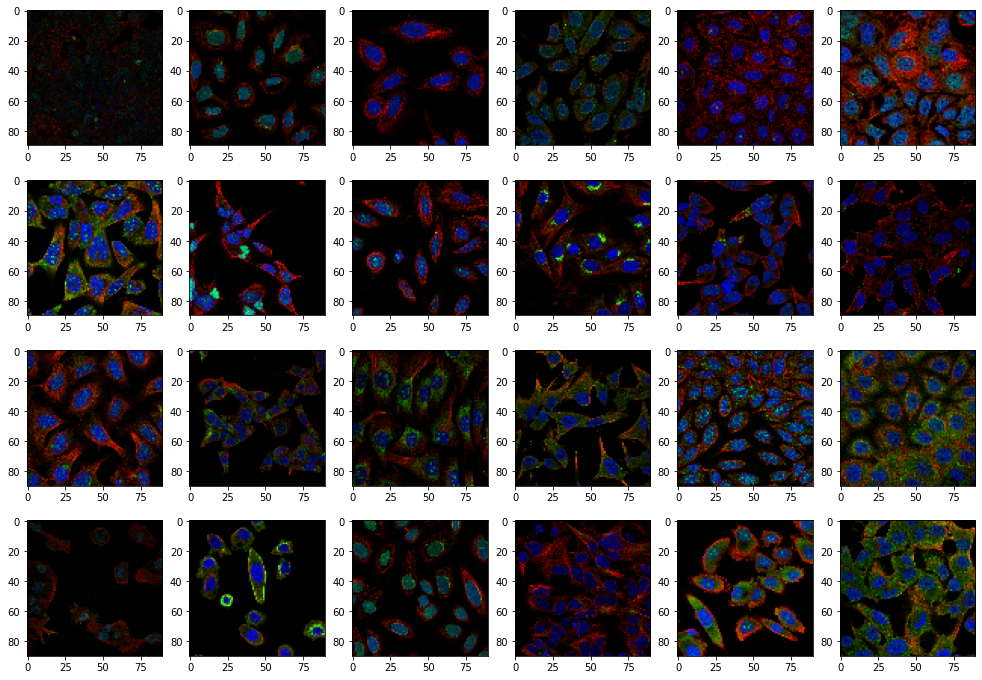

In [19]:
plt.figure(figsize = (17, 12))
for i in range(24):
  plt.subplot(4, 6, i + 1)
  plt.imshow(images[i][0])
plt.show()

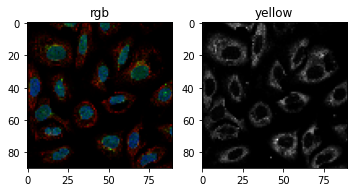

In [20]:
plt.figure(figsize = (12, 4))
colors = ["rgb", "yellow"]
for i in range(2):
  plt.subplot(1, 4, i + 1)
  plt.imshow(images[1][i])
  plt.title(colors[i])
plt.show()

In [25]:
target_after = np.zeros((len(csv_dataset), 28), dtype=int)

In [26]:
target_after.shape

(31072, 28)

In [27]:
target_after[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [29]:
targets = csv_dataset['Target']
for index, tar in enumerate(targets):
  ids = tar.split()
  for id in ids:
    target_after[index, int(id)] = 1

In [30]:
target_after[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

#Suggested neural network architecture:

In [22]:
DenseNet_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet',
                                                   input_shape = (90, 90, 3))
for layer in DenseNet_model.layers:
  layer.trainable = True  
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(
        DenseNet_model, 
        input_shape = (2, 90, 90, 3)
    ),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dropout(0.5)
    ),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.GlobalAveragePooling2D()
    ),
    tf.keras.layers.GlobalAveragePooling1D(name = "GlobalAveragePooling1D"),
    tf.keras.layers.BatchNormalization(name = "BatchNormalization"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(28, activation="sigmoid")
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), loss = "binary_crossentropy" ,
              metrics = ["binary_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2, 2, 2, 1920)    18321984  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 2, 2, 1920)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2, 1920)          0         
 tributed)                                                       
                                                                 
 GlobalAveragePooling1D (Glo  (None, 1920)             0         
 balAveragePooling1D)                                            
                                                                 
 BatchNormalization (BatchNo  (None, 1920)             7

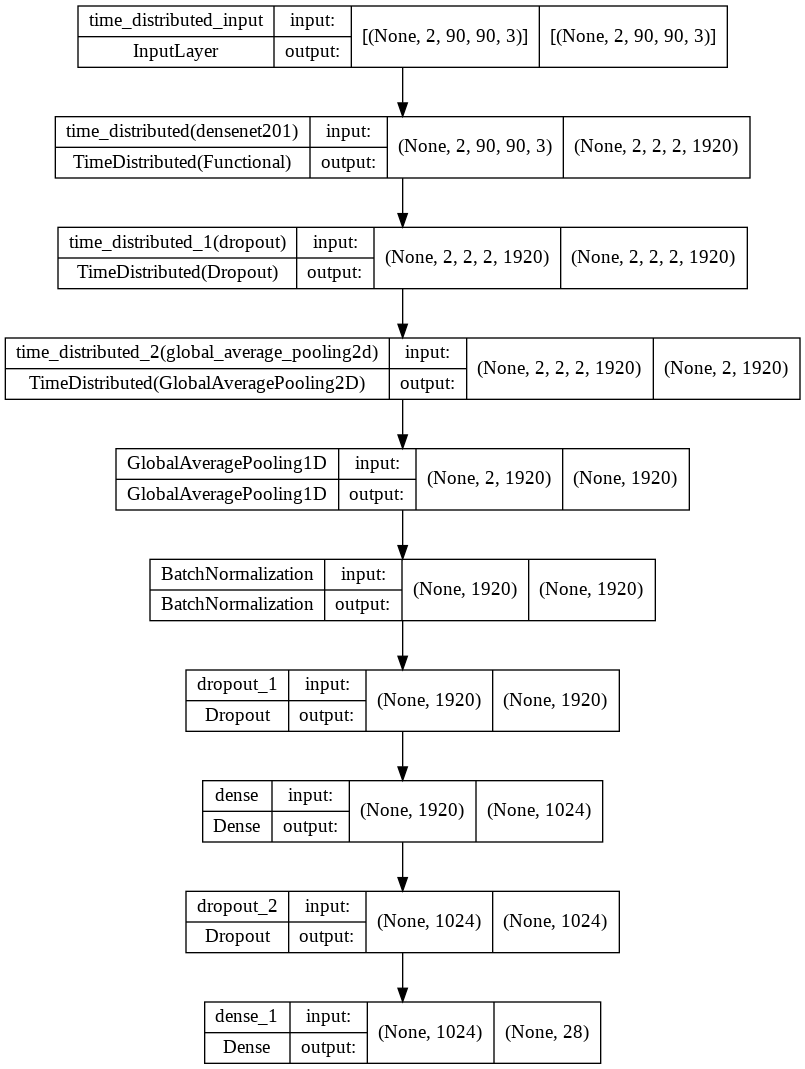

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True,)

In [24]:
history = model.fit(
    images, target_after, epochs = 60, batch_size = 32,
          validation_split = 0.1,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                  patience= 1),
              tf.keras.callbacks.EarlyStopping(patience = 7, monitor = 'val_loss', mode = 'min', restore_best_weights=True)]
)

Epoch 1/60
874/874 [==============================] - 218s 199ms/step - loss: 0.4861 - binary_accuracy: 0.7743 - val_loss: 0.2613 - val_binary_accuracy: 0.9406 - lr: 1.0000e-05
Epoch 2/60
874/874 [==============================] - 165s 189ms/step - loss: 0.2364 - binary_accuracy: 0.9277 - val_loss: 0.1894 - val_binary_accuracy: 0.9443 - lr: 1.0000e-05
Epoch 3/60
874/874 [==============================] - 165s 189ms/step - loss: 0.2021 - binary_accuracy: 0.9389 - val_loss: 0.1731 - val_binary_accuracy: 0.9464 - lr: 1.0000e-05
Epoch 4/60
874/874 [==============================] - 165s 189ms/step - loss: 0.1907 - binary_accuracy: 0.9414 - val_loss: 0.1672 - val_binary_accuracy: 0.9469 - lr: 1.0000e-05
Epoch 5/60
874/874 [==============================] - 165s 189ms/step - loss: 0.1843 - binary_accuracy: 0.9430 - val_loss: 0.1645 - val_binary_accuracy: 0.9475 - lr: 1.0000e-05
Epoch 6/60
874/874 [==============================] - 165s 189ms/step - loss: 0.1800 - binary_accuracy: 0.9432 - va

#Result:

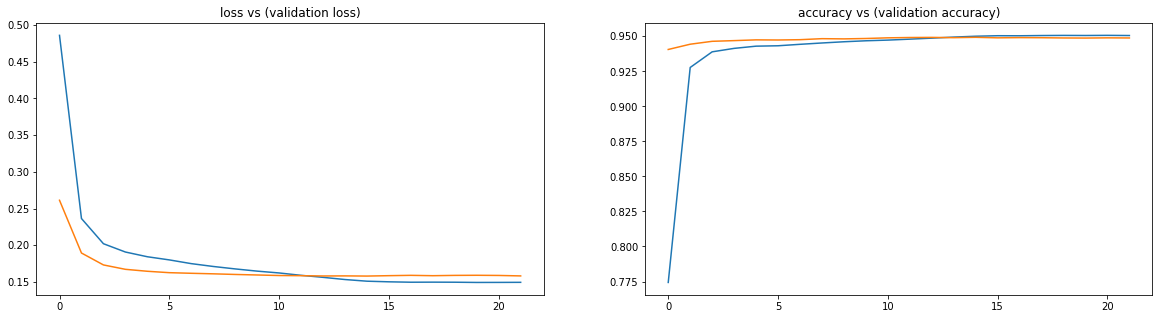

In [25]:
figures = ['loss', "binary_accuracy"]
titles = ["loss vs (validation loss)", "accuracy vs (validation accuracy)"] 
plt.figure(figsize = (20, 5))
for i in range(2):
  plt.subplot(1, 2, (i + 1))
  plt.title(titles[i])
  plt.plot(history.history[figures[i]])
  plt.plot(history.history['val_{}'.format(figures[i])])
plt.show()

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
model.save("drive/MyDrive/protein.h5")
model.save_weights("drive/MyDrive/protein_weights.h5")